## Application to microbiome dataset 

In [ ]:
import os
import copy
import tqdm

import numpy as np
import pandas as pd
import networkx as nx
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

from graphkke.algorithm import m_graphkke
import graphkke.algorithm.kernels as kernels
import graphkke.graph.graph as gl

sns.set(rc={'figure.figsize': (15, 8)})

In [2]:
# Load OTU table
path = '/'.join(os.getcwd().split('/')[:-1] + ['data/real_world/cholera_inf/'])
df = pd.read_csv(path + 'otu_table.txt', sep='\t')

In [3]:
# Preprocess dataset
df = df.drop(columns = ['Unnamed: 0'])
df['labels'] = df.index
df.labels[df.labels.str.contains('recovery')] = '1'
df.labels[df.labels.str.contains('diarrhea')] = '0'

labels = np.array(df.labels, dtype=np.int)
df = df.drop(columns=['labels'])

df = df.fillna(0)
otus = df.loc[:, (df != 0).any(axis=0)]
otus = otus[otus.columns[otus[otus > 0].count() > 0.1 * otus.shape[0]]]

/home/katerynam/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/katerynam/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(111.5, 0.5, 'Time')

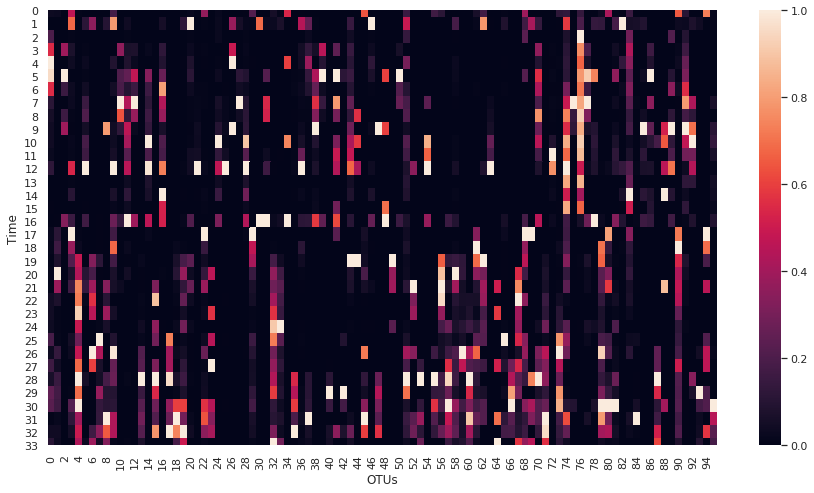

In [4]:
# Relative abundence
sums = np.sum(otus, axis=1)
X = otus / sums[:, None]

X = MinMaxScaler().fit_transform(X)
sns.heatmap(X)
plt.xlabel('OTUs')
plt.ylabel('Time')

Corr table shape:  (96, 96)


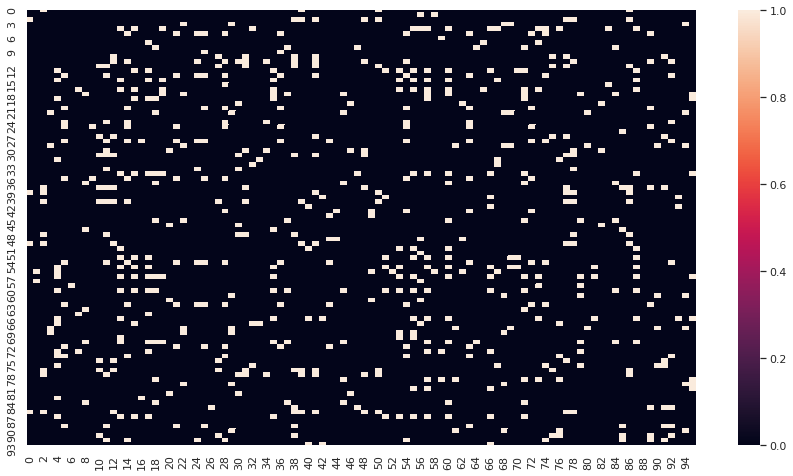

In [5]:
# Construction of the initial co-occurence matrix
threshold = 0.5
corr_table = np.corrcoef(X.T)

print('Corr table shape: ', corr_table.shape)

if threshold == 0:
    initial_matrix = copy.copy(corr_table)
    initial_matrix[initial_matrix != threshold] = 1
else:
    initial_matrix = copy.copy(corr_table)
    initial_matrix[np.where((initial_matrix > -threshold) & (initial_matrix < threshold))] = 0
    initial_matrix[initial_matrix >= threshold] = 1
    initial_matrix[initial_matrix <= -threshold] = 1

np.fill_diagonal(initial_matrix, 0)

init_adj_list = list(zip(np.nonzero(initial_matrix)[0], np.nonzero(initial_matrix)[1]))

sns.heatmap(initial_matrix)

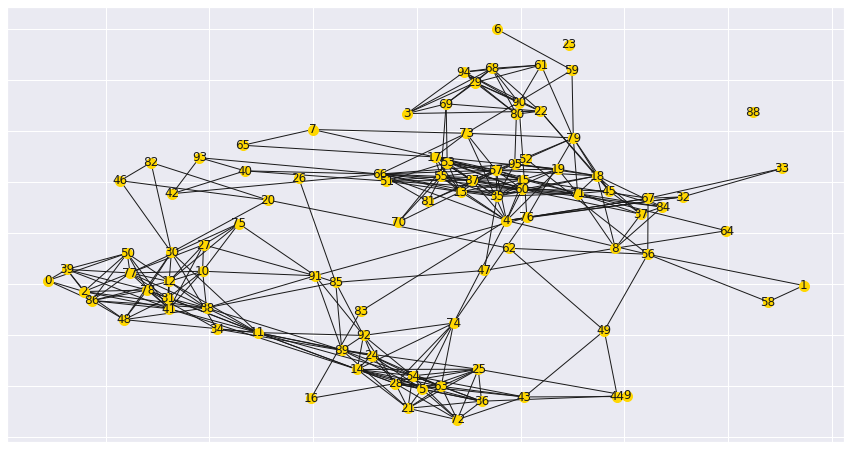

In [6]:
# Plot the initial graph using networkx
fig = plt.figure()
g = nx.Graph(initial_matrix)
pos = nx.spring_layout(g, k=1, iterations=150)
nx.draw_networkx(g, pos, node_color='gold', node_size=100)
plt.show()

In [ ]:
# Adj matrix
inds = list(itertools.combinations(range(initial_matrix.shape[0]), 2))
otus = np.array(X)

adj_matrix = []
for i in tqdm.tqdm(range(otus.shape[0])):
    current_adj_matrix = copy.copy(initial_matrix)
    for pair in inds:
        value = initial_matrix[pair[0], pair[1]] * otus[i][pair[0]] * otus[i][pair[1]]
        current_adj_matrix[pair[0], pair[1]] = value
        current_adj_matrix[pair[1], pair[0]] = value
    adj_matrix.append(normalize(current_adj_matrix)) 
adj_matrix = np.array(adj_matrix)

num_nodes = initial_matrix.shape[0]
node_labels = list(range(num_nodes))

graphs = []
adj_matrix[np.where(adj_matrix != 0)] = 1
for graph in tqdm.tqdm(adj_matrix):
    graph = gl.Graph(graph)
    graph.add_node_labels(node_labels)

    graphs.append(graph)

np.save(path+'adj_matrix.npy')
np.save(path+'graph_labels.npy')

In [ ]:
# Or load adjacency matrices
adj_matrix = np.load(path+'adj_matrix.npy')
labels = np.load(path+'graph_labels.npy')

Computing WlKernel kernel...


/home/katerynam/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/katerynam/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


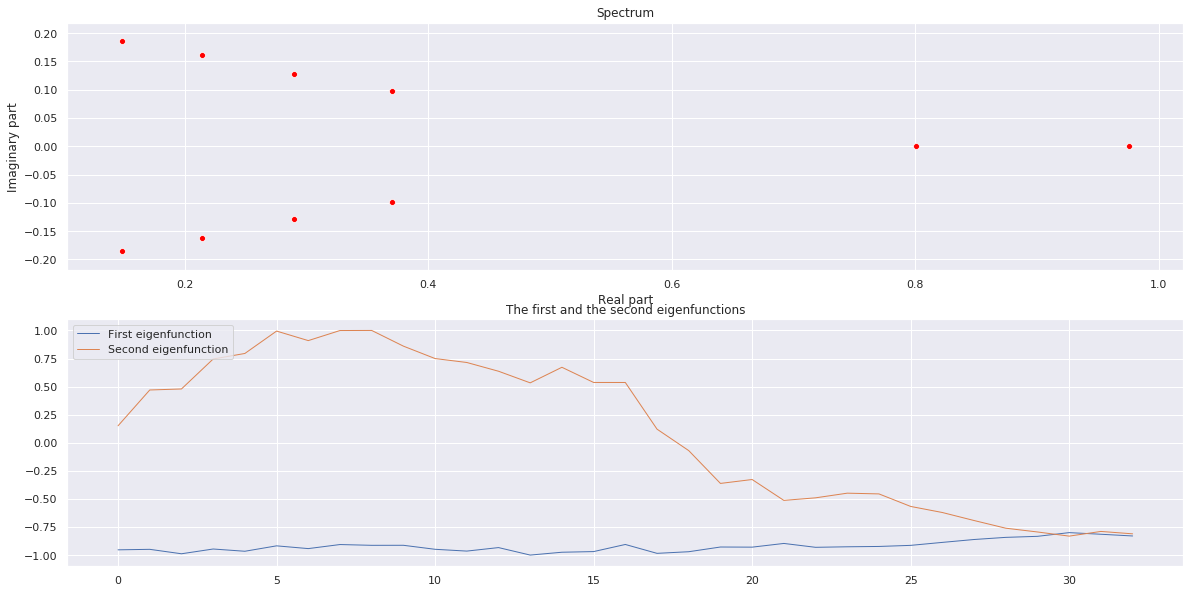

In [8]:
# Hyperparameters of graphKKE
epsilon = 0.5
operator = 'K'
num_iterations = 5
k = kernels.WlKernel(num_iterations)

# Run graphKKE method
m_graphkke.graphkke(graphs, k, tau=1, epsilon=epsilon, outdir=path+'result/')

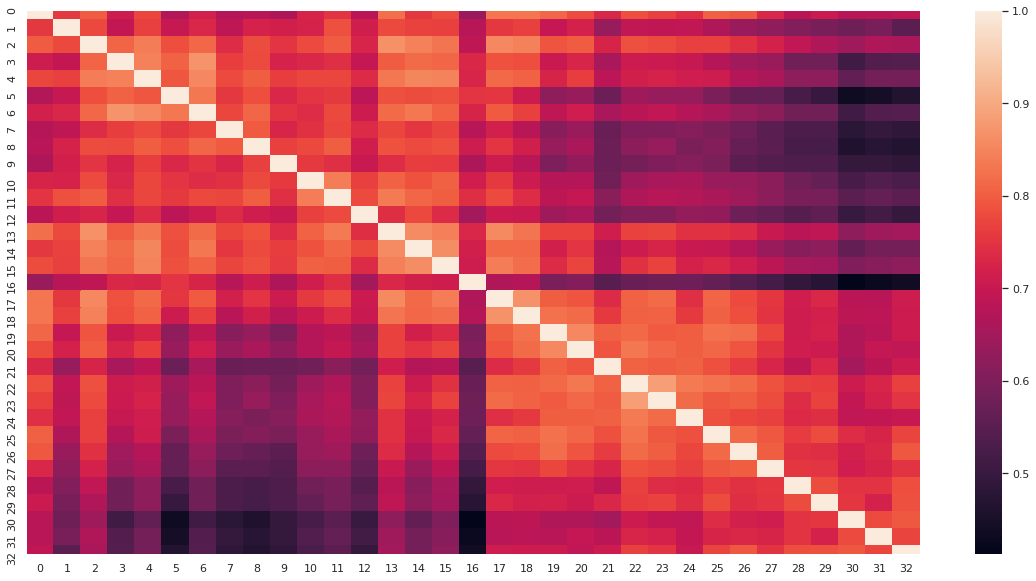

In [9]:
# Load saving metrics
d = np.load(path+'result'
            + '/eigenvalues.npy')
V = np.load(path+'result'
            + '/eigenvectors.npy')
G_xx = np.load(path+'result'
               + '/gramm.npy')

sns.heatmap(G_xx)

In [10]:
# Compute ARI 
epochs = 30
aris = []
for i in range(epochs):
    kmeans = KMeans(n_clusters=2).fit(np.real(V[:, :2]))
    aris.append(adjusted_rand_score(labels[:-1], kmeans.labels_) * 100)
    
print("Mean: ", np.mean(aris))
print("STD: ", np.std(aris))

Mean:  87.8767005338385
STD:  2.842170943040401e-14


In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(epsilons, aris, s=250, marker='s', color='gold', zorder=2)
sns.lineplot(epsilons, aris, color='goldenrod', zorder=1)

plt.xlabel('Regularization parameter', fontsize=20)
plt.ylabel('ARI', fontsize=20)
plt.savefig(path+'ari.png', bbox_inches='tight')

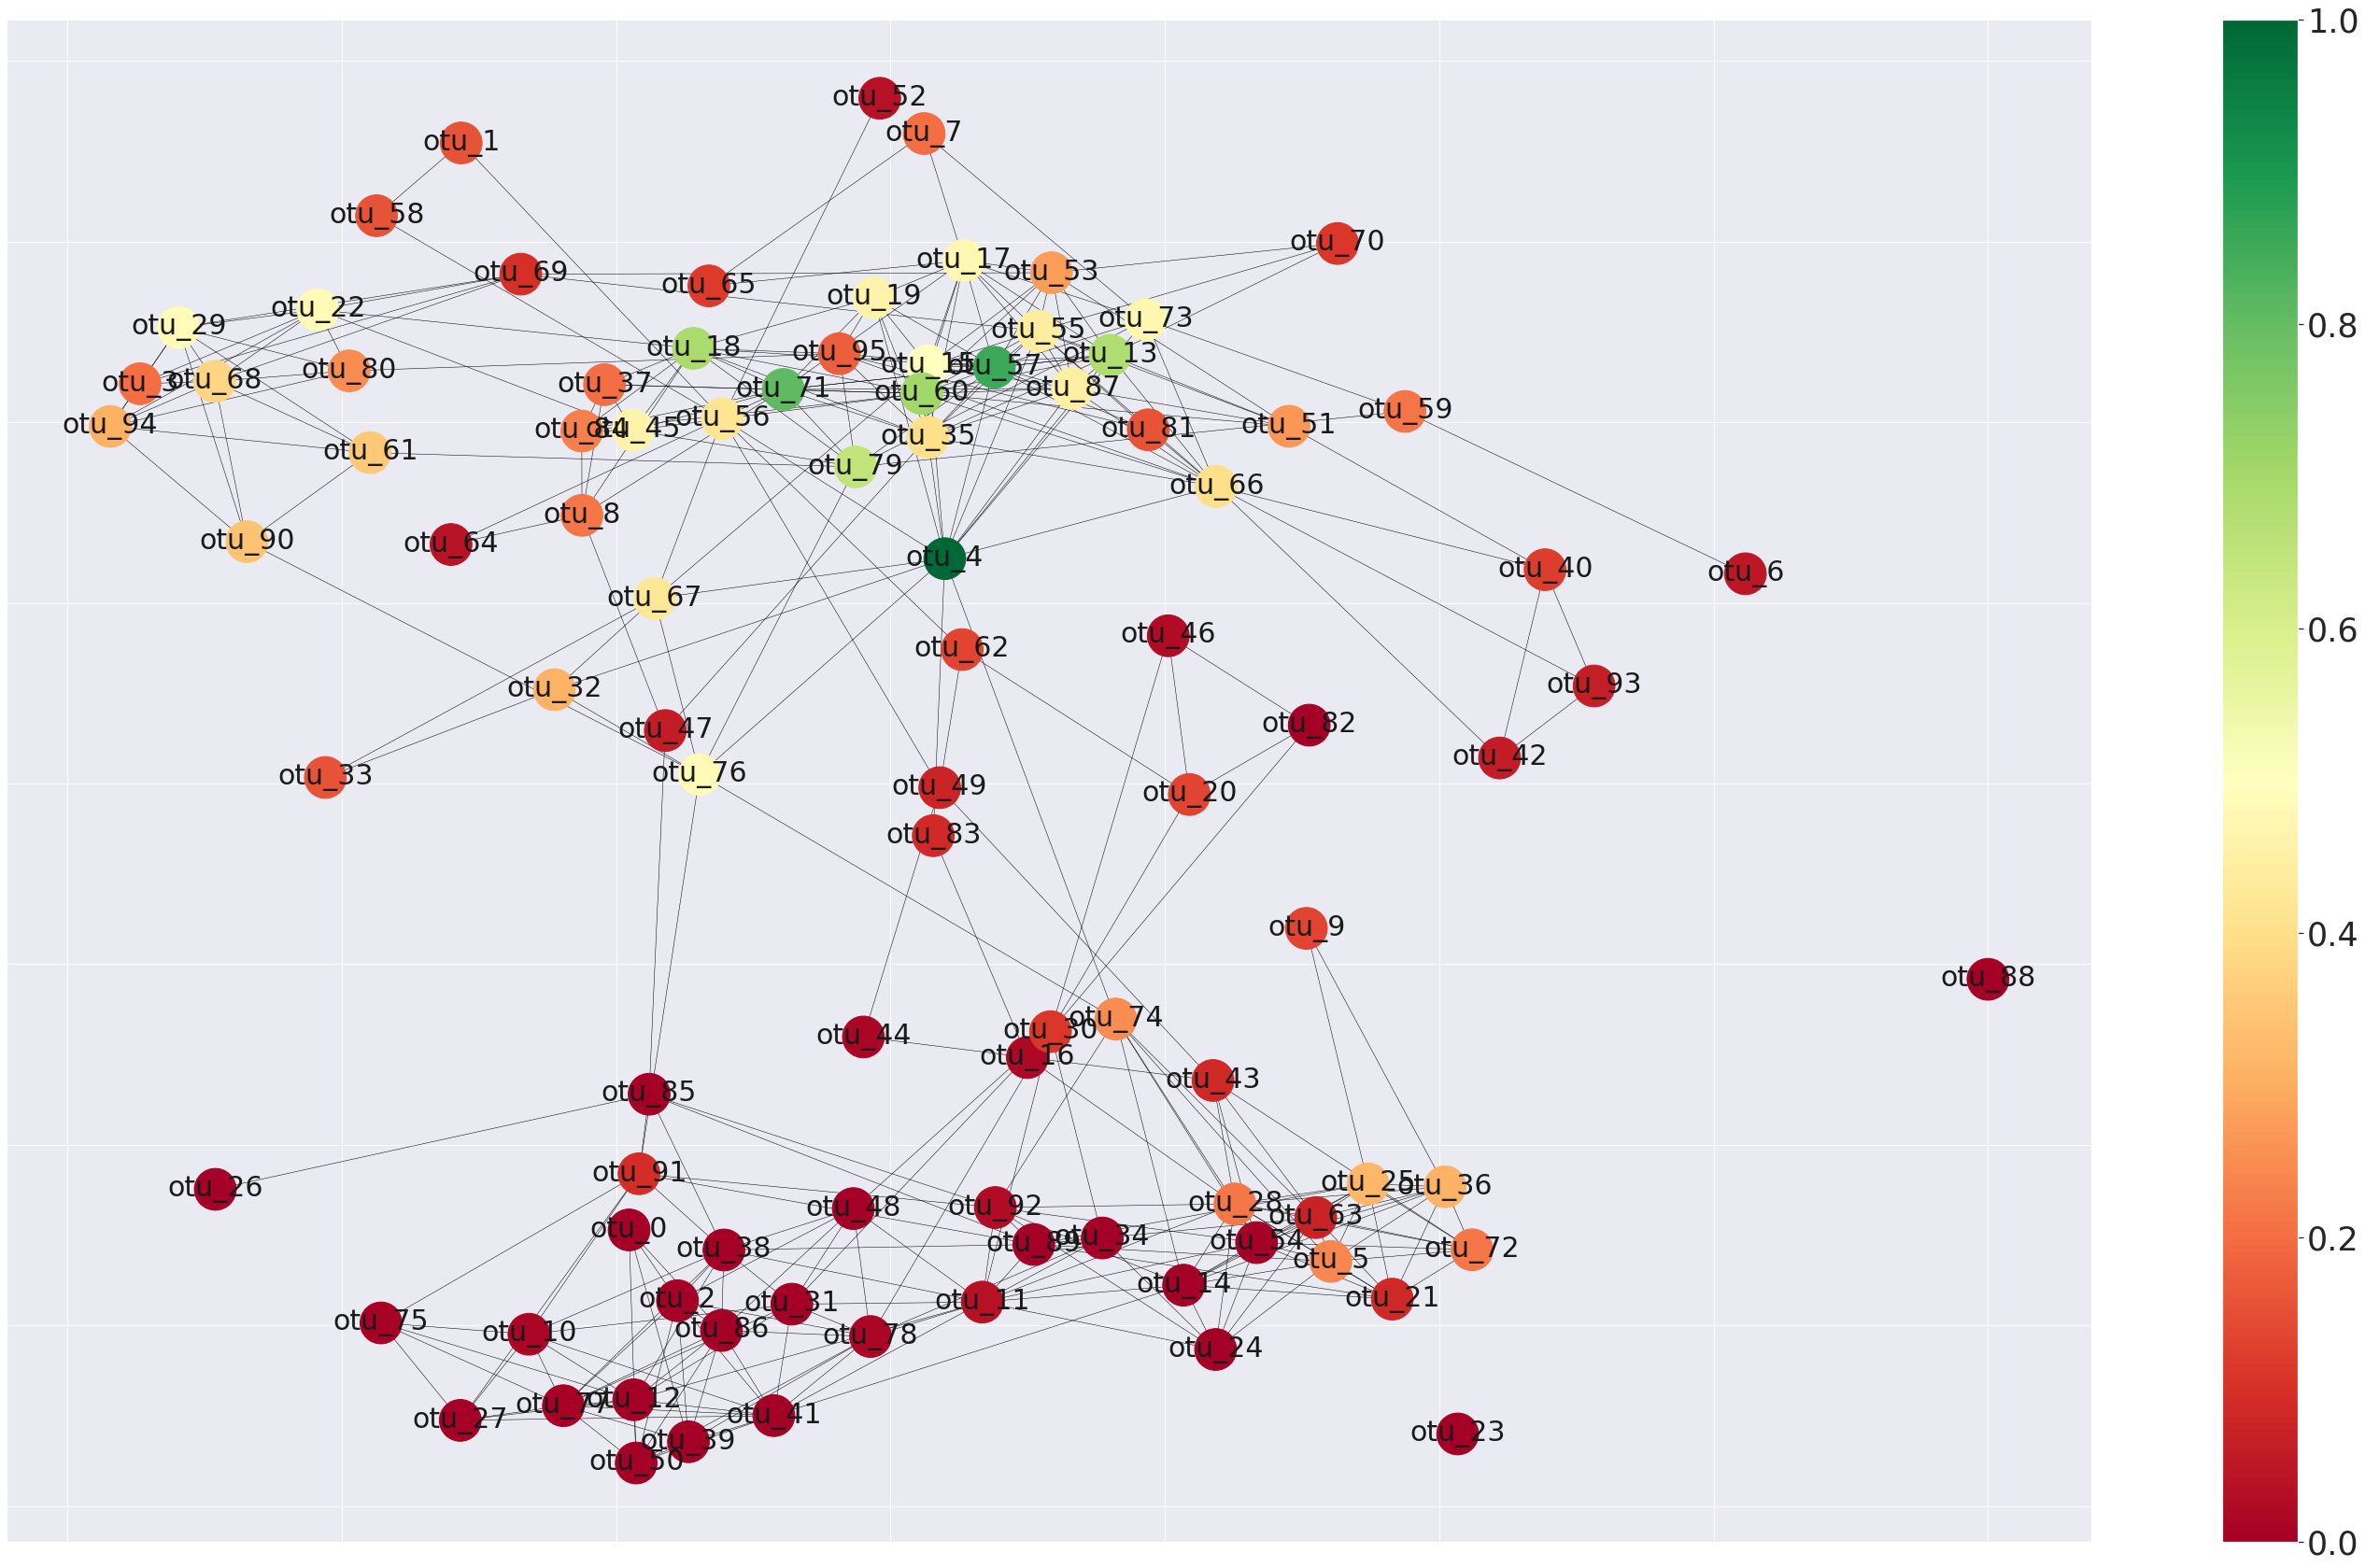

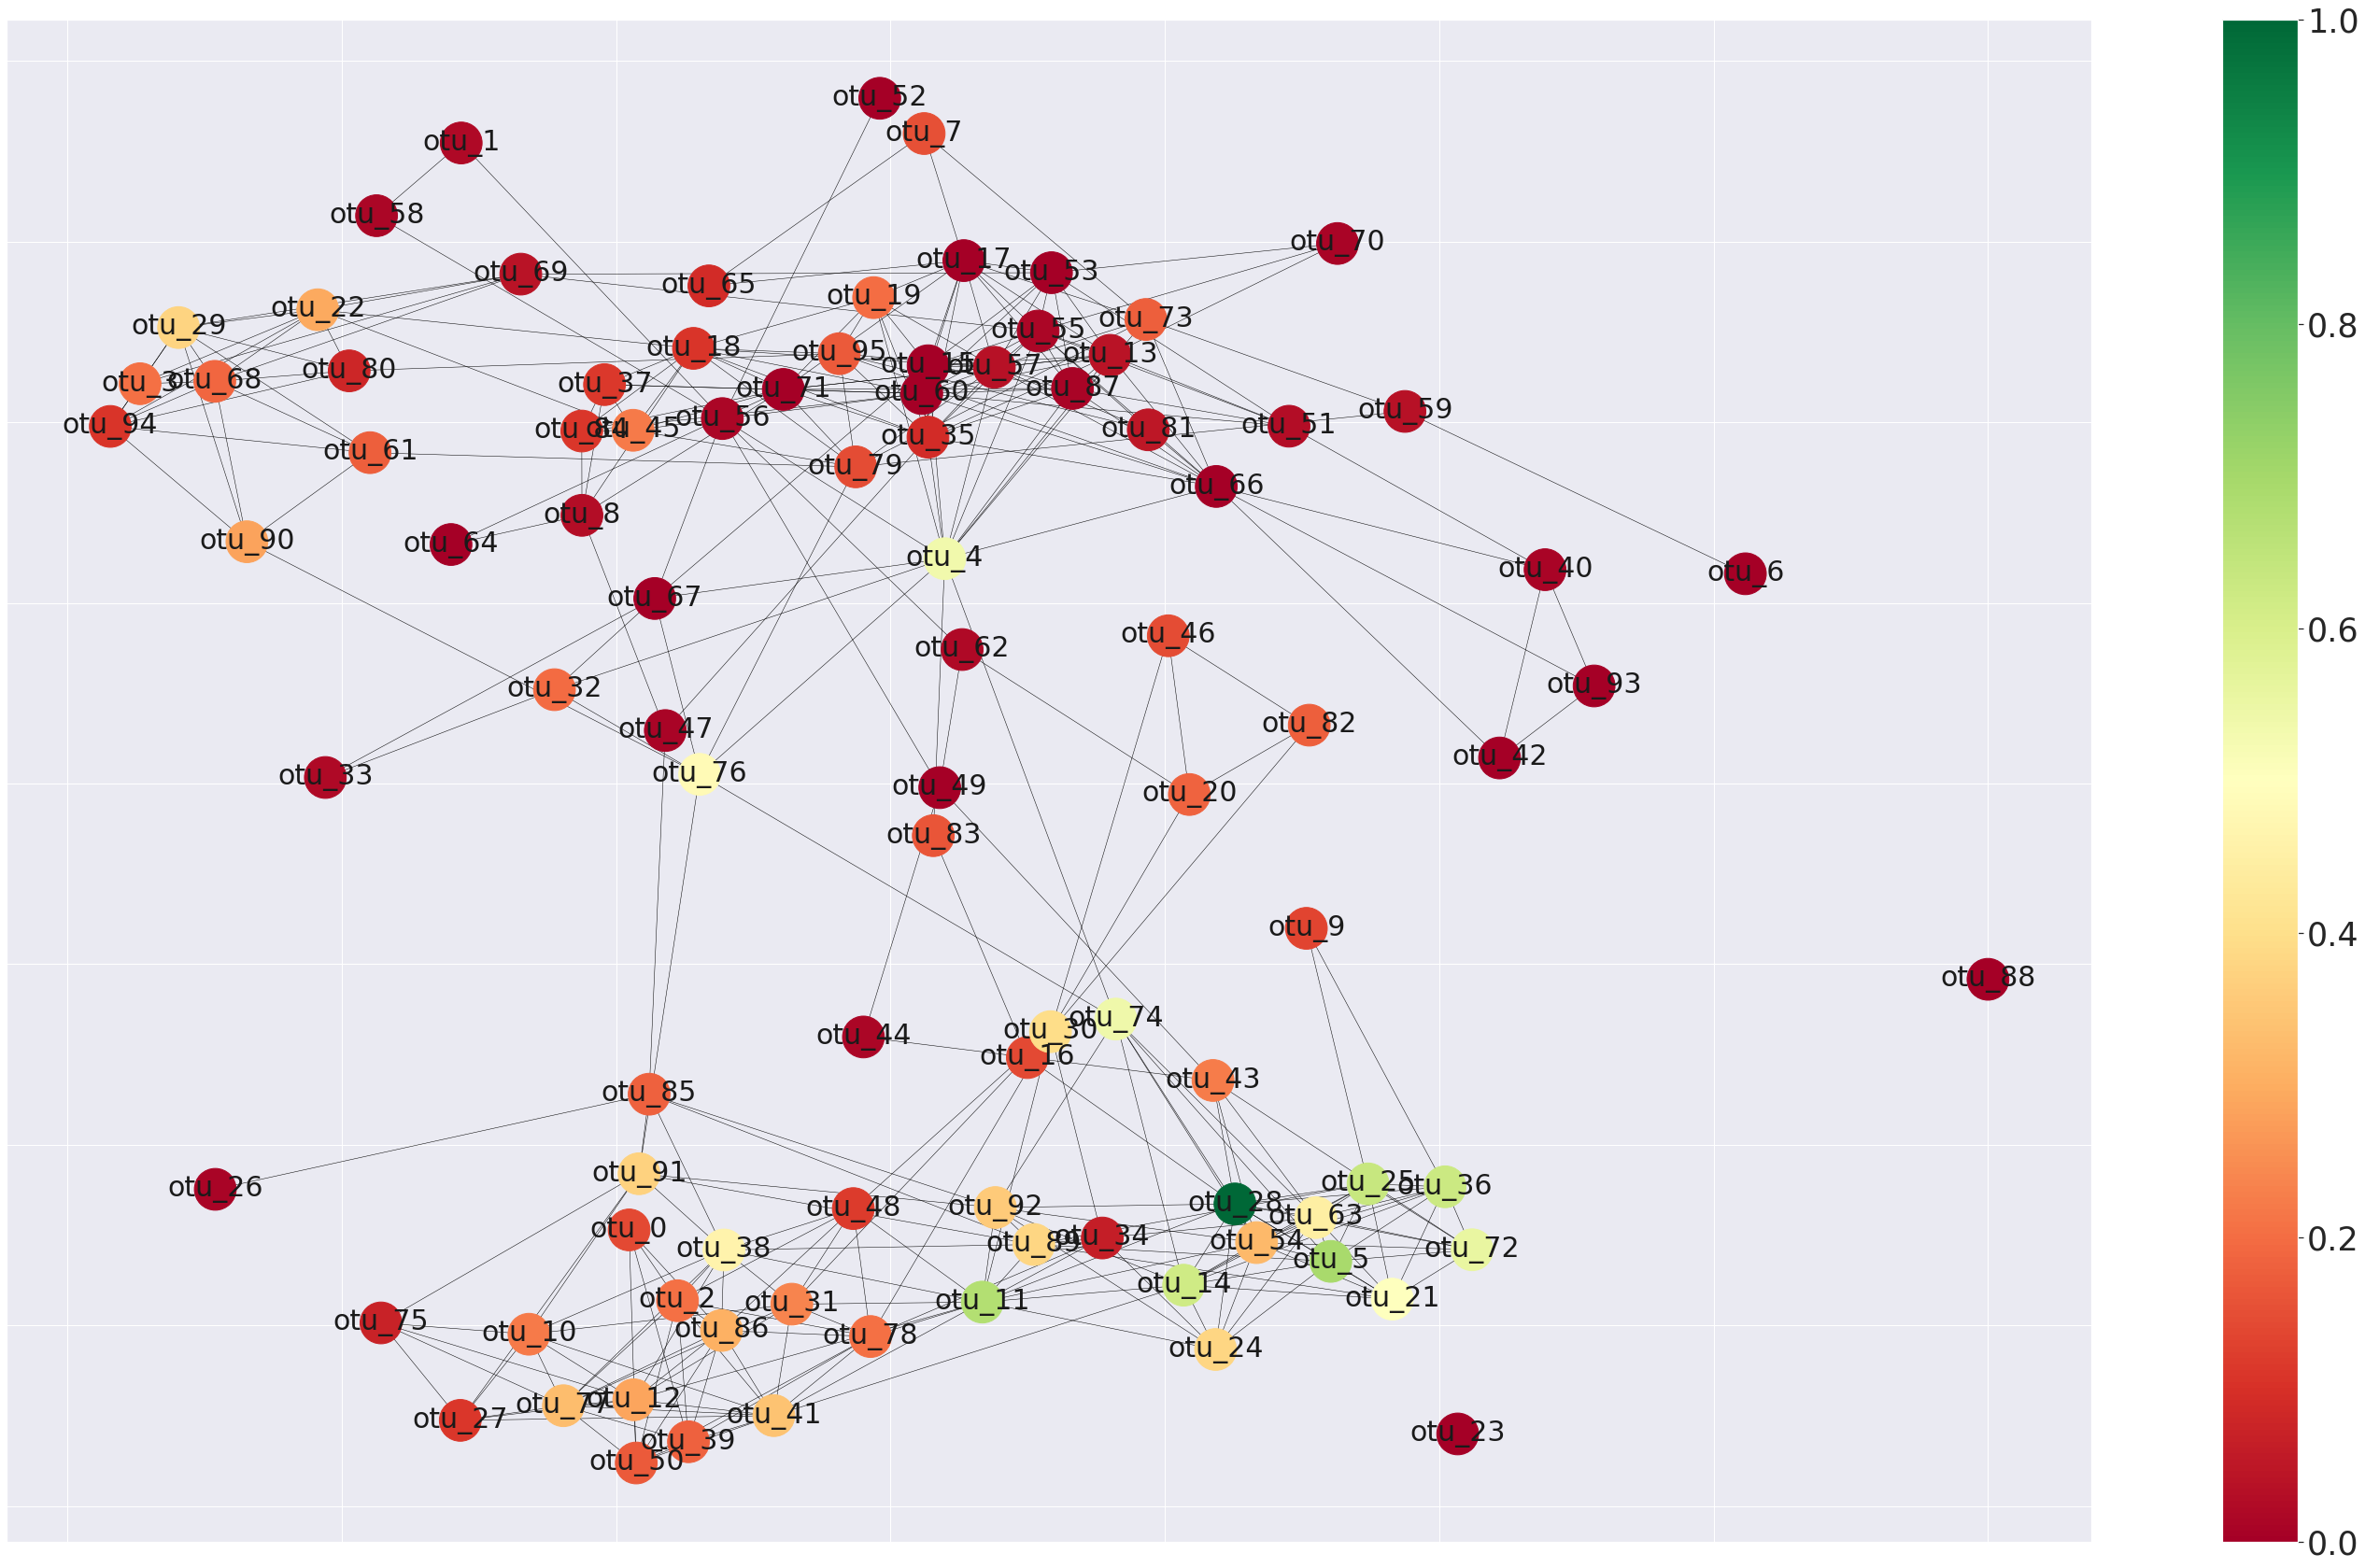

In [16]:
# Plot the average graph for each of the states
adj_matrix = np.array([graph.get_adj_matrix() for graph in graphs])
kmeans = KMeans(n_clusters=2).fit(np.real(V[:, :2]))
y_pred = kmeans.labels_

g = nx.Graph(initial_matrix)
pos  = nx.spring_layout(g, k=1, iterations=150)

avg_graphs_pred = []
unique_labels = np.unique(y_pred)

for label in unique_labels:
    ind = np.argwhere(y_pred == label).flatten()
    one_avg_graph = np.mean(adj_matrix[ind, :], axis = 0)
    avg_graphs_pred.append(one_avg_graph)
avg_graphs__pred = np.array(avg_graphs_pred)

name_nodes = list(df.columns)
labels_dict = {1:'recovery', 0:'diarrhea'}
unique_labels = np.unique(y_pred)
dict_nodes = dict(zip(g.nodes(), [f'otu_{i}' for i in g.nodes()]))

graphs_pred = copy.copy(avg_graphs_pred)
sns.set(rc={'figure.figsize': (50, 30)})

for i in range(len(graphs_pred)):
    fig, ax = plt.subplots()
    count_nodes = np.count_nonzero(graphs_pred[i], axis=1)
    sum_nodes = np.sum(graphs_pred[i], axis=0)

    cmap = plt.cm.RdYlGn
    nx.draw_networkx_labels(g, pos, dict_nodes, font_size=30)
    
    nx.draw_networkx(g, pos=pos, edge_color='black',
                     node_color=sum_nodes, with_labels=False, node_size=2000, width=0.5, cmap=cmap)
    
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    
    font_size = 35
    cbar.ax.tick_params(labelsize=font_size)
    plt.savefig(os.path.join((path, f'result/clusters_{i}.png'), bbox_inches='tight')